<a href="https://colab.research.google.com/github/franciscodlsb/OXMLSS2020/blob/master/DL101_part_2_OXML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 101 Tutorial for OxML 2020
### Prepared by Melvin Selim Atay
# Tutorial Objectives: 

*   Learn and implement convolution operation.
*   Get intuition about deep convolutional neural networks (CNNs). 
*   Learn properties of CNNs, implement and train a CNN model





   For convenience we will be using well-known datasets available in PyTorch dataset library, it is possible to customize the dataset loaders for your needs.











In [ ]:
#@title Imports
%matplotlib inline
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

import numpy as np
# Import torch and create the alias "th"
# instead of writing torch.name_of_a_method() , we only need to write th.name_of_a_method()
# (similarly to numpy imported as np)
import torch as th

In [ ]:
#@title Plotting Functions

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#@title Add GPU support
if th.cuda.is_available():
  # Create tensors
  x = th.ones(1000, 1000)
  y = 2 * x + 3
  # Do the calculation on cpu (default)
  start_time = time.time()
  # Matrix multiplication (for benchmark purpose)
  results = th.mm(x, y)
  time_cpu = time.time() - start_time
  
  # Do the same calculation but on the gpu
  # First move tensors to gpu
  x = x.to("cuda")
  y = y.to("cuda")
  start_time = time.time()
  # Matrix multiplication (for benchmark purpose)
  results = th.mm(x, y)
  time_gpu = time.time() - start_time
  
  print("Time on CPU: {:.5f}s \t Time on GPU: {:.5f}s".format(time_cpu, time_gpu))
  print("Speed up: Computation was {:.0f}X faster on GPU!".format(time_cpu / time_gpu))
  
else:
  print("You need to enable GPU accelaration in colab (runtime->change runtime type)")

Time on CPU: 0.02287s 	 Time on GPU: 0.00097s
Speed up: Computation was 23X faster on GPU!



For this tutorial, we will use the CIFAR10 dataset.
There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![CIFAR10](http://pytorch.org/tutorials/_images/cifar10.png)


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [ ]:
#@title Import Torchvision
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#@title Seed the random generator to have reproducible results:
seed = 2020
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


In [ ]:
#@title Setting random sampler
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

Files already downloaded and verified
Files already downloaded and verified
      bird        dog      truck       frog


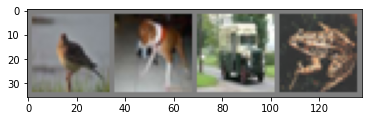

In [ ]:
#@title Load data, set train, test and validation splits and show some of the training images
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [ ]:
#@title Import torch.nn and functional api
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

### PyTorch functions to build the network

In PyTorch, there are built-in functions that carry out the convolution steps for you.

- **nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0):** Convolution layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#conv2d)

- **nn.MaxPool2d(kernel_size, stride=None, padding=0):** Max pooling layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#maxpool2d)

- **F.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#torch.nn.ReLU)

- **x.view(new_shape)**: Returns a new tensor with the same data but different size. It is the equivalent of numpy function *reshape* (Gives a new shape to an array without changing its data). You can read the full documentation [here.](http://pytorch.org/docs/master/tensors.html#torch.Tensor.view)

- **nn.Linear(in_features, out_features):** Applies a linear transformation to the incoming data: $y = Ax + b$, it is also called a fully connected layer. You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#linear-layers)



How convolution works in 2D: 

![picture](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

Source: https://commons.wikimedia.org/wiki/File:2D_Convolution_Animation.gif

**Convolution Formulas**:

The formulas relating the output shape $(C_2, H_2, W_2)$ of the convolution to the input shape $(C_1, H_1, W_1)$ are:


$$ H_2 = \lfloor \frac{H_1 - kernel\_size + 2 \times padding}{stride} \rfloor +1 $$

$$ W_2 = \lfloor \frac{W_1 - kernel\_size + 2 \times padding}{stride} \rfloor +1 $$

$$ C_2 = \text{number of filters used in the convolution}$$

NOTE: $C_2 = C_1$ in the case of max pooling

where:
- $H_2$: height of the output volume  
- $W_2$: width of the output volume  
- $C_1$: in_channels, number of channels in the input volume
- $C_2$: out_channels

In [ ]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

#### Example of use of helper method get_output_size() 

 *input volume of size 3x32x32* (where 3 is the number of channels)
 2D convolution with the following parameters:

```python
conv1 = nn.Conv2d(3, 18, kernel_size=7, stride=2, padding=1)
```
then, the size of the output volume is 18x?x? (because we have 18 filters) where ? is given by the convolution formulas 

**get_output_size()** function allows to compute that size:

```
out_size = get_output_size(in_size=32, kernel_size=7, stride=2, padding=1)
print(out_size) # prints 14
```

 *the output volume is 18x14x14*

In [ ]:
out_size = get_output_size(in_size=32, kernel_size=3, stride=1, padding=1)
print(out_size)

32


#### Simple Convolutional Neural Network

ConvNet with one convolution layer followed by a max pooling operation,
one fully connected layer and an output layer

In [ ]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

### Define a loss function and optimizer

Let's use a Classification Cross-Entropy loss and ADAM (optionally, SGD with momentum). You can read more about  [optimization methods](https://pytorch.org/docs/stable/optim.html).

![picture](https://gombru.github.io/assets/cross_entropy_loss/intro.png)

![picture](https://gombru.github.io/assets/cross_entropy_loss/multiclass_multilabel.png)

Image sources: https://gombru.github.io



In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

###  Train the network


We have to loop over our data iterator, feed the inputs to the network, and optimize.

#### Training loop
The training script: it takes ~10s per epoch with batch_size = 32


In [ ]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [ ]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [ ]:
net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.08 took: 0.65s
Epoch 1, 20% 	 train_loss: 1.89 took: 0.57s
Epoch 1, 30% 	 train_loss: 1.74 took: 0.60s
Epoch 1, 40% 	 train_loss: 1.63 took: 0.57s
Epoch 1, 50% 	 train_loss: 1.56 took: 0.56s
Epoch 1, 60% 	 train_loss: 1.52 took: 0.57s
Epoch 1, 70% 	 train_loss: 1.50 took: 0.57s
Epoch 1, 80% 	 train_loss: 1.48 took: 0.58s
Epoch 1, 90% 	 train_loss: 1.44 took: 0.60s
Validation loss = 1.34
Epoch 2, 10% 	 train_loss: 1.33 took: 0.64s
Epoch 2, 20% 	 train_loss: 1.35 took: 0.55s
Epoch 2, 30% 	 train_loss: 1.35 took: 0.55s
Epoch 2, 40% 	 train_loss: 1.34 took: 0.57s
Epoch 2, 50% 	 train_loss: 1.32 took: 0.57s
Epoch 2, 60% 	 train_loss: 1.35 took: 0.56s
Epoch 2, 70% 	 train_loss: 1.31 took: 0.57s
Epoch 2, 80% 	 train_loss: 1.30 took: 0.57s
Epoch 2, 90% 	 train_loss: 1.25 took: 0.59s
Validation loss = 1.26
Epoch 3, 10% 	 train_loss: 1.19 took: 0.65s
Epoch 3, 20% 	 train_loss: 1.17 took: 0.5

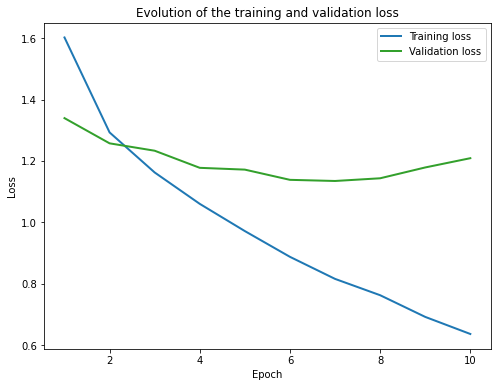

In [ ]:
plot_losses(train_history, val_history)

###  Test the network on the test data


We have trained the network for 2 passes over the training dataset.
We need to check if network learnt.
We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.




Ground truth:

      bird        car        dog       bird


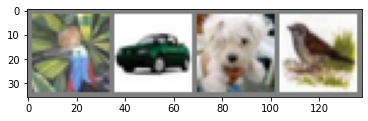

In [ ]:
#@title Ground truth images
try:
  images, labels = next(iter(test_loader))
except EOFError:
  pass

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth:\n")

print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

torch.Size([4, 10])
Predicted:

      bird        car       deer       bird


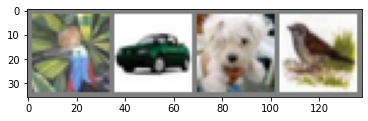

In [ ]:
outputs = net(images.to(device))
print(outputs.size())

_, predicted = torch.max(outputs, 1)

print("Predicted:\n")
imshow(torchvision.utils.make_grid(images))

print(' '.join('{:>10}'.format(classes[predicted[j]]) for j in range(test_batch_size)))

How network performs over the test set:

In [ ]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 20000 train images: 74.67 %
Accuracy of the network on the 5000 validation images: 60.54 %
Accuracy of the network on the 5000 test images: 61.80 %


To determine the accuracy further we compute accuracy per class and confusion matrix.

In [ ]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        68.44   
car          82.38   
bird         38.48   
cat          34.00   
deer         53.45   
dog          55.33   
frog         84.32   
horse        66.26   
ship         70.63   
truck        65.30   


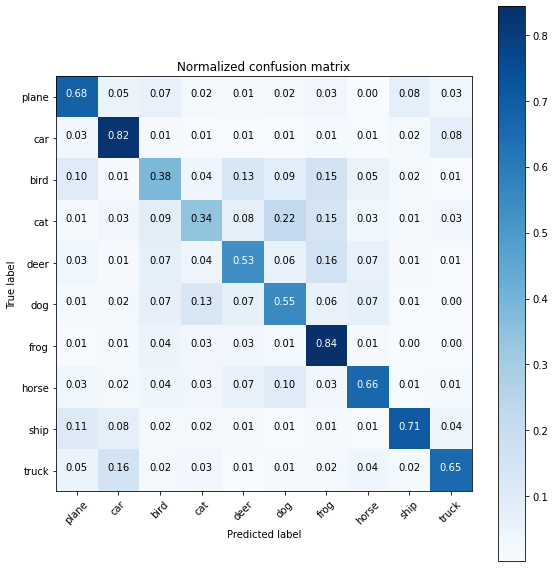

In [ ]:
#@title Normalized Confusion Matrix Plot
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

Play with your own custom convolutional neural network and compare!

In [ ]:
#@title 2 Layer CNN
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        self.conv2 = nn.Conv2d(18, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Size of the output of the last convolution:
        self.flattened_size = 18 * 8 * 8
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        
        #### START CODE: USE YOUR NEW LAYERS HERE ####
        x =  F.relu(self.conv2(x))
        # 18x16x16 -> 18x8x8
        x = self.pool(x)
        
        #### END CODE ####
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
#@title Train 2 layer CNN
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.18 took: 0.69s
Epoch 1, 20% 	 train_loss: 1.95 took: 0.63s
Epoch 1, 30% 	 train_loss: 1.84 took: 0.63s
Epoch 1, 40% 	 train_loss: 1.77 took: 0.63s
Epoch 1, 50% 	 train_loss: 1.67 took: 0.59s
Epoch 1, 60% 	 train_loss: 1.61 took: 0.63s
Epoch 1, 70% 	 train_loss: 1.56 took: 0.63s
Epoch 1, 80% 	 train_loss: 1.54 took: 0.59s
Epoch 1, 90% 	 train_loss: 1.50 took: 0.62s
Validation loss = 1.39
Epoch 2, 10% 	 train_loss: 1.40 took: 0.68s
Epoch 2, 20% 	 train_loss: 1.36 took: 0.60s
Epoch 2, 30% 	 train_loss: 1.35 took: 0.61s
Epoch 2, 40% 	 train_loss: 1.36 took: 0.63s
Epoch 2, 50% 	 train_loss: 1.34 took: 0.63s
Epoch 2, 60% 	 train_loss: 1.33 took: 0.62s
Epoch 2, 70% 	 train_loss: 1.31 took: 0.61s
Epoch 2, 80% 	 train_loss: 1.34 took: 0.60s
Epoch 2, 90% 	 train_loss: 1.33 took: 0.63s
Validation loss = 1.26
Epoch 3, 10% 	 train_loss: 1.18 took: 0.68s
Epoch 3, 20% 	 train_loss: 1.29 took: 0.6

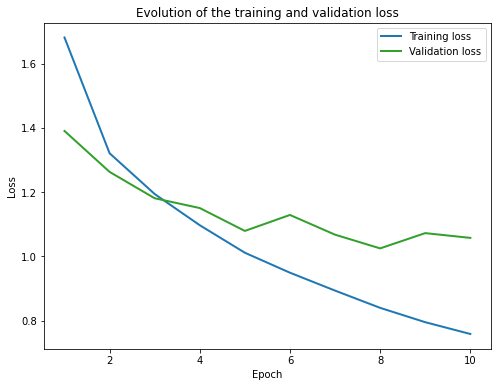

In [ ]:
#@title Plot Losses
plot_losses(train_history, val_history)

In [ ]:
#@title Compute Accuracy
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 73.74 %
Accuracy of the network on the 5000 validation images: 65.04 %
Accuracy of the network on the 5000 test images: 63.66 %


In [ ]:
#@title Compute Accuracy Per Class
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        72.13   
car          79.01   
bird         55.86   
cat          41.65   
deer         55.42   
dog          46.52   
frog         77.80   
horse        68.89   
ship         80.36   
truck        59.06   


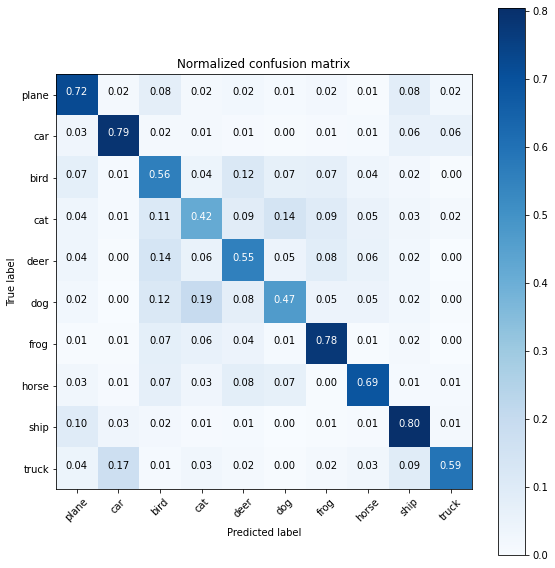

In [ ]:
#@title Plot Confusion Matrix 
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
out_size = get_output_size(in_size=18, kernel_size=3, stride=1, padding=1)
print(out_size)

18


In [ ]:
class CustomConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(CustomConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        # self.conv2 = ...
        
        # Size of the output of the last convolution:
        self.flattened_size = 18 * 16 * 16
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        
        #### START CODE: USE YOUR NEW LAYERS HERE ####
        # x = ...
        
        #### END CODE ####
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
#@title Train custom CNN
net = CustomConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.08 took: 0.66s
Epoch 1, 20% 	 train_loss: 1.84 took: 0.57s
Epoch 1, 30% 	 train_loss: 1.73 took: 0.57s
Epoch 1, 40% 	 train_loss: 1.64 took: 0.56s
Epoch 1, 50% 	 train_loss: 1.60 took: 0.57s
Epoch 1, 60% 	 train_loss: 1.53 took: 0.57s
Epoch 1, 70% 	 train_loss: 1.50 took: 0.58s
Epoch 1, 80% 	 train_loss: 1.48 took: 0.59s
Epoch 1, 90% 	 train_loss: 1.48 took: 0.58s
Validation loss = 1.38
Epoch 2, 10% 	 train_loss: 1.33 took: 0.66s
Epoch 2, 20% 	 train_loss: 1.32 took: 0.58s
Epoch 2, 30% 	 train_loss: 1.33 took: 0.59s
Epoch 2, 40% 	 train_loss: 1.29 took: 0.59s
Epoch 2, 50% 	 train_loss: 1.30 took: 0.57s
Epoch 2, 60% 	 train_loss: 1.28 took: 0.58s
Epoch 2, 70% 	 train_loss: 1.30 took: 0.60s
Epoch 2, 80% 	 train_loss: 1.24 took: 0.60s
Epoch 2, 90% 	 train_loss: 1.27 took: 0.62s
Validation loss = 1.25
Epoch 3, 10% 	 train_loss: 1.19 took: 0.65s
Epoch 3, 20% 	 train_loss: 1.17 took: 0.6

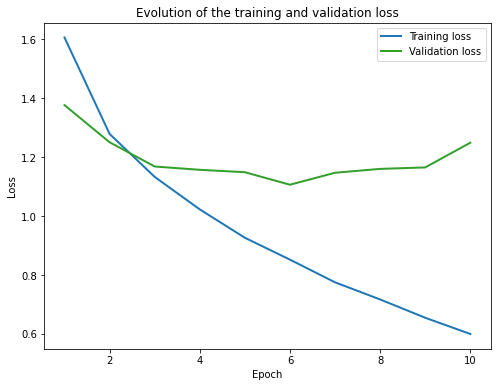

In [ ]:
#@title Plot Losses
plot_losses(train_history, val_history)

In [ ]:
#@title Compute Accuracy
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 74.70 %
Accuracy of the network on the 5000 validation images: 61.82 %
Accuracy of the network on the 5000 test images: 60.62 %


In [ ]:
#@title Compute Accuracy Per Class
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        72.34   
car          78.81   
bird         40.82   
cat          41.85   
deer         47.53   
dog          53.28   
frog         65.99   
horse        71.92   
ship         71.03   
truck        63.16   


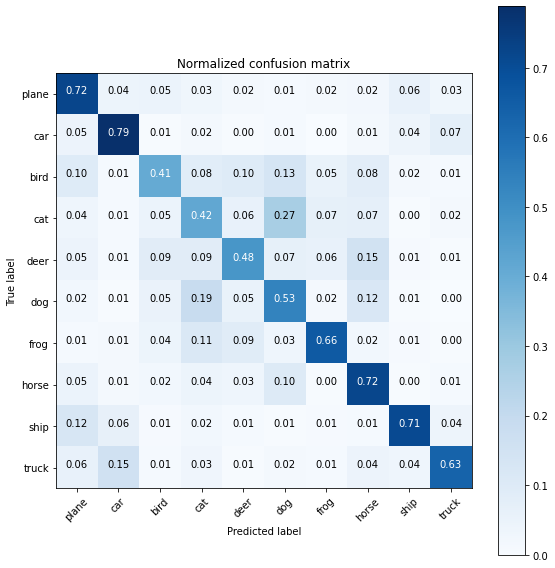

In [ ]:
#@title Plot Confusion Matrix 
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

This tutorial is edited version of official [pytorch](https://colab.research.google.com/drive/1B5KQvPySqYEa6XicRHdOwgv8fN1BrCgQ) tutorials.